In [138]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import pickle
from scipy import stats



# load data

In [139]:
with open('../../data/movies.pkl', 'rb') as file:
    movies = pickle.load(file)

len(movies)


68214

### US selection

In [140]:
# function that extract if movies was created in US

def count_country(data, country = "United States of America"):
    '''
    goal : count if a given country is in the list of countries
    input: the dataset and the country of interest
    output: the number of times a country is the data
    '''
    total = 0
    for j in data:
        if j is not None:
            total += j.count(country)
    return total

# we will apply the function count_country to divide US movies from non us movies
# a US movie is a movie where US appears once

us =  movies["Movie_countries"].apply(lambda x: count_country(x))
us_movies = movies.copy()
us_movies["count_us"] = us

nonus_movies = us_movies.loc[us_movies["count_us"]==0]
us_movies = us_movies.loc[us_movies["count_us"]>0]



### get list of all genres 

In [141]:
#get the list of genre

genres_unique = []
for j in movies["Movie_genres"]:
    if j is not None:
        for genre in j:
            genres_unique.append(genre)
genres_unique = np.unique(genres_unique)

In [142]:
#function to count the genre
def count_genre(data, genre):
    '''
    function that countes the occurence of a given genre in the data 
    '''
    total = 0
    for j in data["Movie_genres"]:
        if j is not None:
            total += j.count(genre)
    return total

def plot_percentage_movies_genre(data, genre, year_initial, year_end, focus_year,ax, fig):
    '''
    a function that plot the percentage of a given genre as a function of time
        the percentage is defined as the occurence the given genre divided by the total numbe of genres

    input 
        data: the dataset
        genre: the genre that we docus on
        year_initial: the beginning of the period we focus on 
        year_end: the end of the period we focus on
        focus_year: the year the event we study appears
        ax,fig: used later for subplots
    '''
    genre = genre  

    # count the number of movies that have the given genre per year 
    movies_year = data.groupby(data.Movie_release_date.dt.year).apply(lambda x: count_genre(x, genre)).reset_index()
    movies_year.columns = ["year", "count"]

    # get the total number of genre for a given year, a movies with 5 genres will add 5 to the total count  
    #if we want to divise by the total number of movies, change by sum by count 
    yearly_movies = data.groupby(data.Movie_release_date.dt.year)['nb_genre'].agg('sum')

    #percentage of a given genre
    percentage = movies_year.loc[(movies_year.year>year_initial) & (movies_year.year<year_end)]["count"]/yearly_movies[(yearly_movies.index >year_initial) & (yearly_movies.index < year_end)].values*100

    #plot
    ax.plot(movies_year.loc[(movies_year.year > year_initial  )&( movies_year.year < year_end)]["year"], percentage, color ='b')
    ax.plot([focus_year,focus_year],[percentage.min(), percentage.max()], color = 'r' )
    ax.set_title(genre)
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.set_xticks(np.arange(year_initial, year_end, 1))
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
    fig.text(0.04, 0.5, 'percentage of movies from given genre per year', ha='center', rotation='vertical')
    ax.grid()

def plot_percentage_movies_genre_all(data, genres, year_initial, year_end, focus_year,nrows,ncols):
    '''
    a function that wraps up the plots for various genres with a subplor with nrows and ncols 
    
    '''
    fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(15,25))

    for i in range(nrows):
        for j in range(ncols):
            ax = axs[i][j]
            plot_percentage_movies_genre(data, genres[i*ncols+j], year_initial, year_end, focus_year, ax, fig)



In [143]:
def get_movies_genre_change(data, genres_unique, nb_genres, year_initial, year_middle, year_end):
    '''
    a function that provides as an output a sorted dataset with a first column genre,
    a second count_before the percentage of occurence of the given genre between year_innitial and year_middle
    a third count_after the percentage of occurence of the given genre between year_middle and year_end
    a last columns with increase/ decrease in the occurence by evaluatinf the difference between the ones before and after divided by the percentage before 
    
    the function also take as input genres_uniques the list of genres in the dataset
    nb_genres  
    '''
    # total number of genres for movies before and after the specified year range
    before_yearly_movies = data.groupby(data.Movie_release_date.dt.year)['nb_genre'].agg('sum').reset_index()
    sum_before_yearly_movies = before_yearly_movies.loc[
        (before_yearly_movies.Movie_release_date > year_initial) & 
        (before_yearly_movies.Movie_release_date < year_middle)
    ]["nb_genre"].sum()

    after_yearly_movies = data.groupby(data.Movie_release_date.dt.year)['nb_genre'].agg('sum').reset_index()
    sum_after_yearly_movies = after_yearly_movies.loc[
        (after_yearly_movies.Movie_release_date >= year_middle) & 
        (after_yearly_movies.Movie_release_date < year_end)
    ]["nb_genre"].sum()

    movies_before = data.loc[
        (data.Movie_release_date.dt.year > year_initial) & 
        (data.Movie_release_date.dt.year < year_middle)
    ]
    movies_after = data.loc[
        (data.Movie_release_date.dt.year >= year_middle) & 
        (data.Movie_release_date.dt.year < year_end)
    ]


    genre_count_before = [0 for i in range(len(genres_unique))]
    genre_count_after = [0 for i in range(len(genres_unique))]
    genre_count_diff = [0 for i in range(len(genres_unique))]

    # Calculate the percentage of each genre before and after the
    for i in range(len(genres_unique)):
        sum = 0
        for j in movies_after["Movie_genres"]:
            if j is not None:
                sum += j.count(genres_unique[i])
        genre_count_after[i] = sum / sum_after_yearly_movies * 100

        sum= 0
        for j in movies_before["Movie_genres"]:
            if j is not None:
                sum += j.count(genres_unique[i])
        genre_count_before[i] = sum  / sum_before_yearly_movies * 100
        if genre_count_before[i] != 0:
            genre_count_diff[i] =  (genre_count_after[i] -   genre_count_before[i])/genre_count_before[i]
        else :
             genre_count_diff[i] = 0

    
    df = pd.DataFrame({
        'genre': genres_unique,
        'count_before': genre_count_before,
        'count_after': genre_count_after,
        'count_diff': genre_count_diff
    })
    df["abs_diff"] = df['count_diff'].apply(lambda x: np.abs(x))

    # top genres based on `count_diff`
    df = df.sort_values(by="abs_diff", ascending=False).head(nb_genres)
    genres = df['genre'].values  

    return df

def plot_movies_genre_change(df):
        '''
        a function that plots a barplots for before and after the middleyear 
        '''
        fig, ax = plt.subplots(figsize=(15, 8))
        width = 0.35
        x = np.arange(len(df.genre))  # 

        bars_before = ax.bar(x - width/2, df['count_before'], width, label='Before event', color='blue')
        bars_after = ax.bar(x + width/2, df['count_after'], width, label='After event', color='orange')

        ax.set_xticks(x)
        ax.set_xticklabels(df.genre, rotation=90)  
        ax.set_title("Genre distribution before and after event")
        ax.set_ylabel("Percentage (%)")
        #ax.set_yscale("log")  
        ax.legend()

        plt.tight_layout()
        plt.show()

    



# 9/11 US

The genres with the highest change are social issues, horror, political cinema

In [144]:
df = get_movies_genre_change(us_movies, genres_unique, -1 , 1997,  2002,2006)

In [145]:
print(df.count_before.describe())
print("median")
print(df.count_before.median())

count    358.000000
mean       0.279330
std        0.863199
min        0.000000
25%        0.000000
50%        0.031966
75%        0.146510
max        9.738945
Name: count_before, dtype: float64
median
0.031965903036760786


In [146]:
print(df.count_after.describe())
print("median")
print(df.count_after.median())

count    358.000000
mean       0.279330
std        0.814473
min        0.000000
25%        0.000000
50%        0.034737
75%        0.165002
max        8.536691
Name: count_after, dtype: float64
median
0.03473729917498915


We notice here that the distribution of genres is right skewed, with a maximum percentage lower than 10% and a median around 0.03%. We should keep this in mind when we will the percentage and the focus should be more on the change than the absolute value

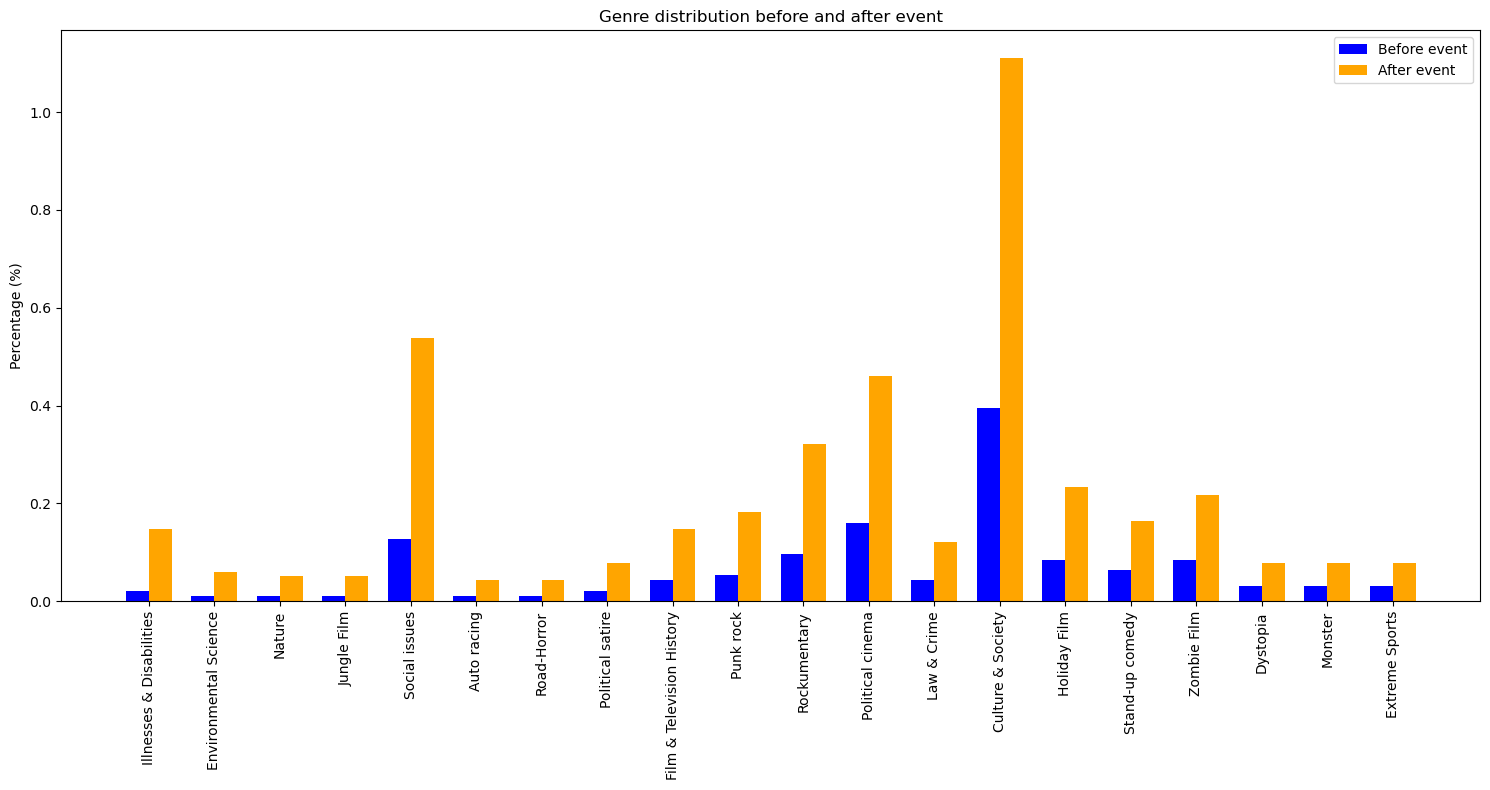

t-statistic: -2.3999224911889345
p-value: 0.021405089343880673


In [147]:
df = get_movies_genre_change(us_movies, genres_unique, 20, 1997,  2002,2006)
plot_movies_genre_change(df)
t_statistic, p_value = stats.ttest_ind(df.count_before, df.count_after)

print("t-statistic:", t_statistic)
print("p-value:", p_value)

for the 20 genres the most changing, there is a significant difference 

In [148]:
# from these 20 genres we focus on the ones linked to politics and social 
genres = ['Social issues', 'Road-Horror','Political satire', 'Film & Television History','Political cinema', 'Law & Crime',
       'Culture & Society','Zombie Film', 'Dystopia', 'Monster']

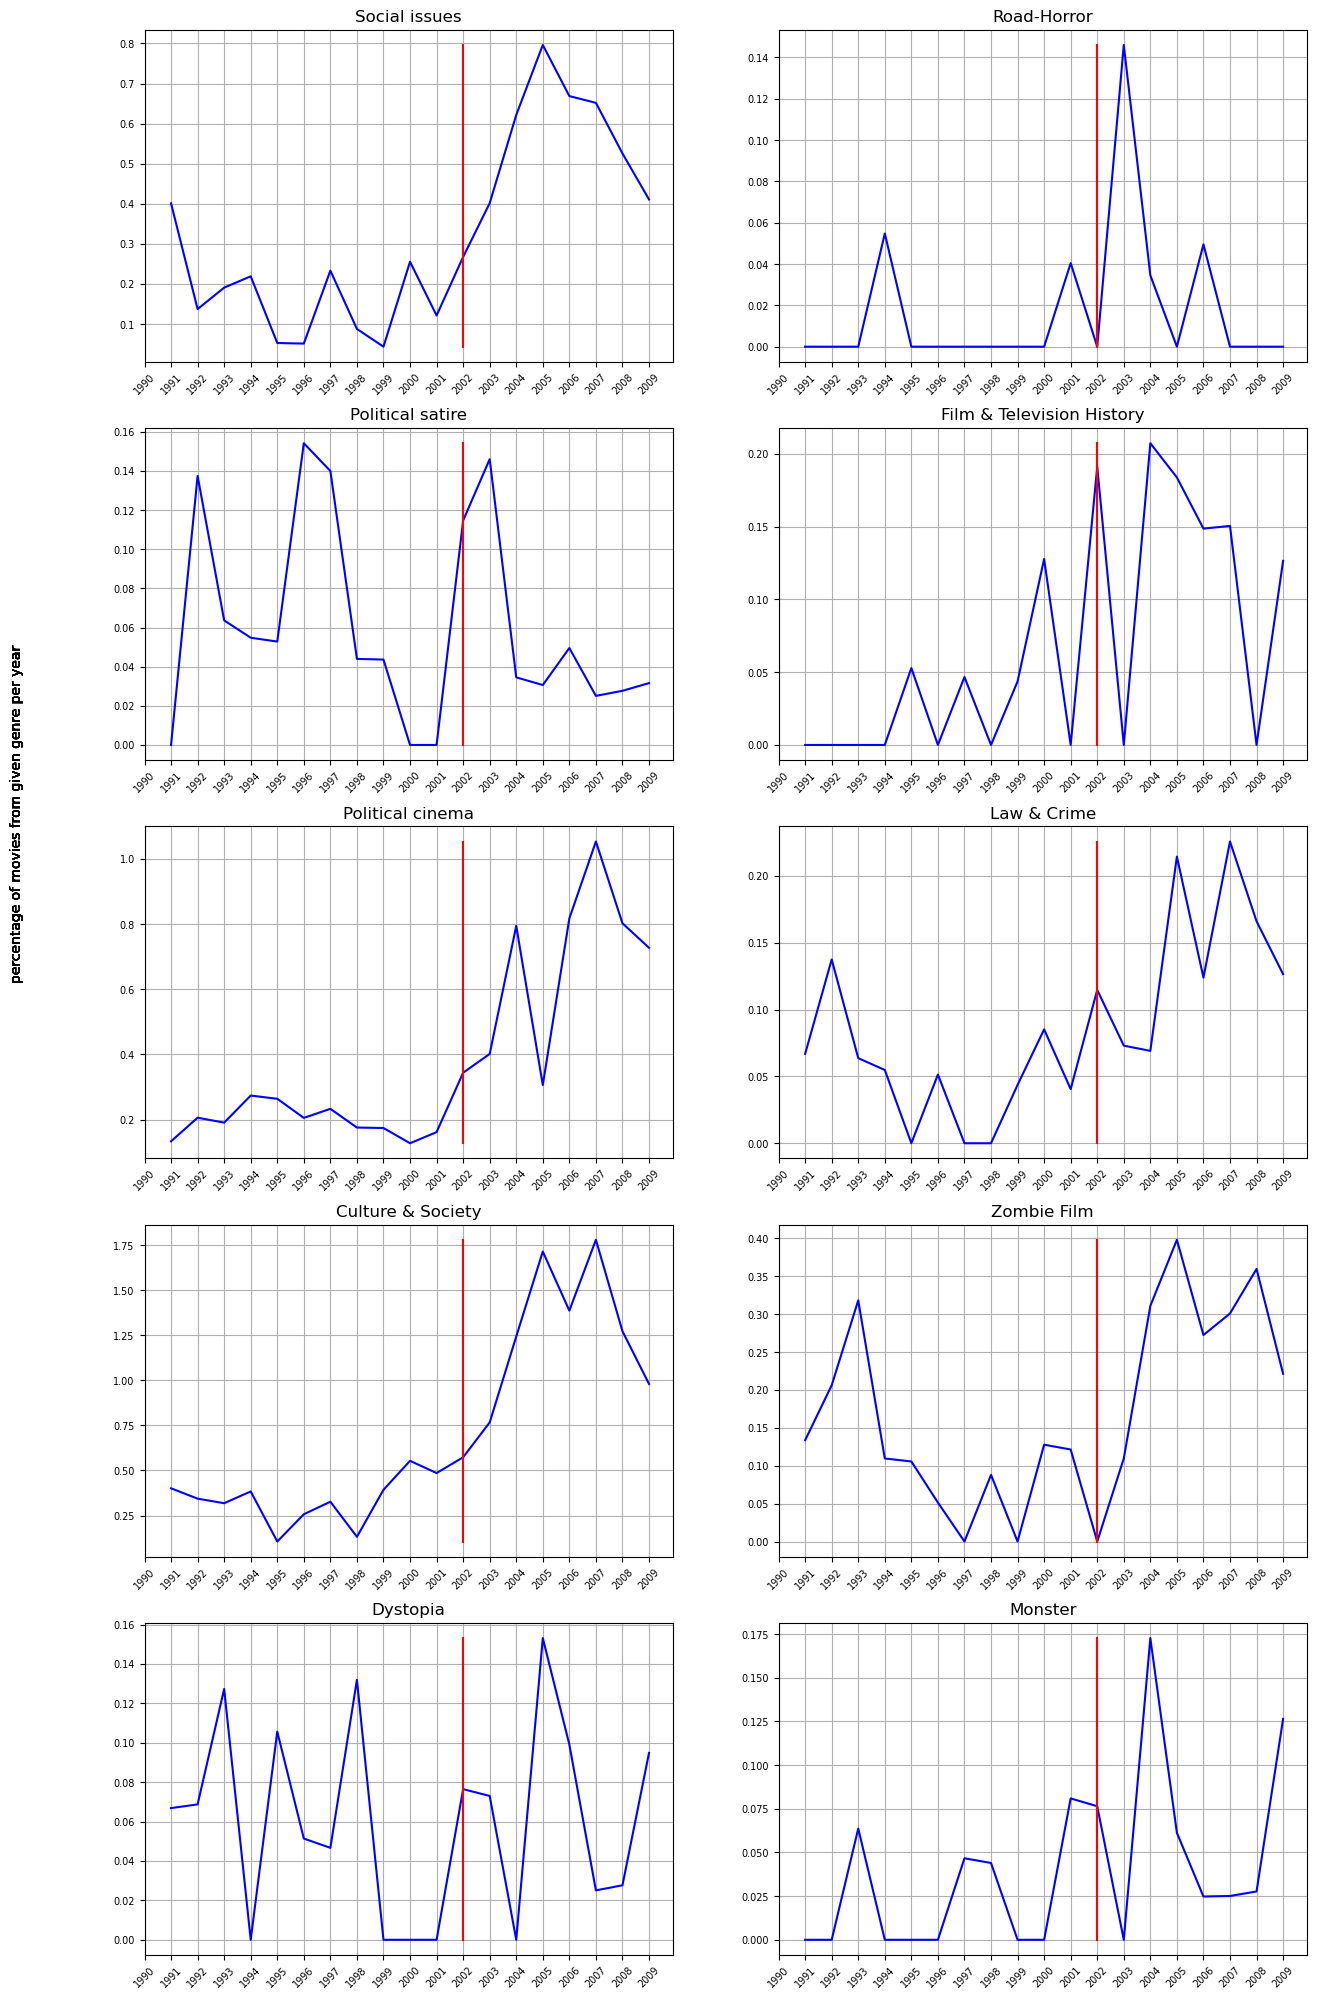

In [153]:
df = get_movies_genre_change(us_movies, genres_unique, 10, 1997,  2002,2006)
#genres =['Social issues','Road-Horror','Political cinema','Political satire', 'Law & Crime','Illnesses & Disabilities','Holiday Film','Social problem film','Glamorized Spy Film','Swashbuckler films','Dystopia', 'Documentary']
plot_percentage_movies_genre_all(us_movies,genres,1990, 2010, 2002,5,2)

We notice an upward trend in the social issues genre after 2002. A similar pattern appears in political cinema, where the trend shifts from a decrease to an increase. Additionally, the road horror genre shows a peak after 2002

In [150]:
# linear regression for political cinema

# Non US movies

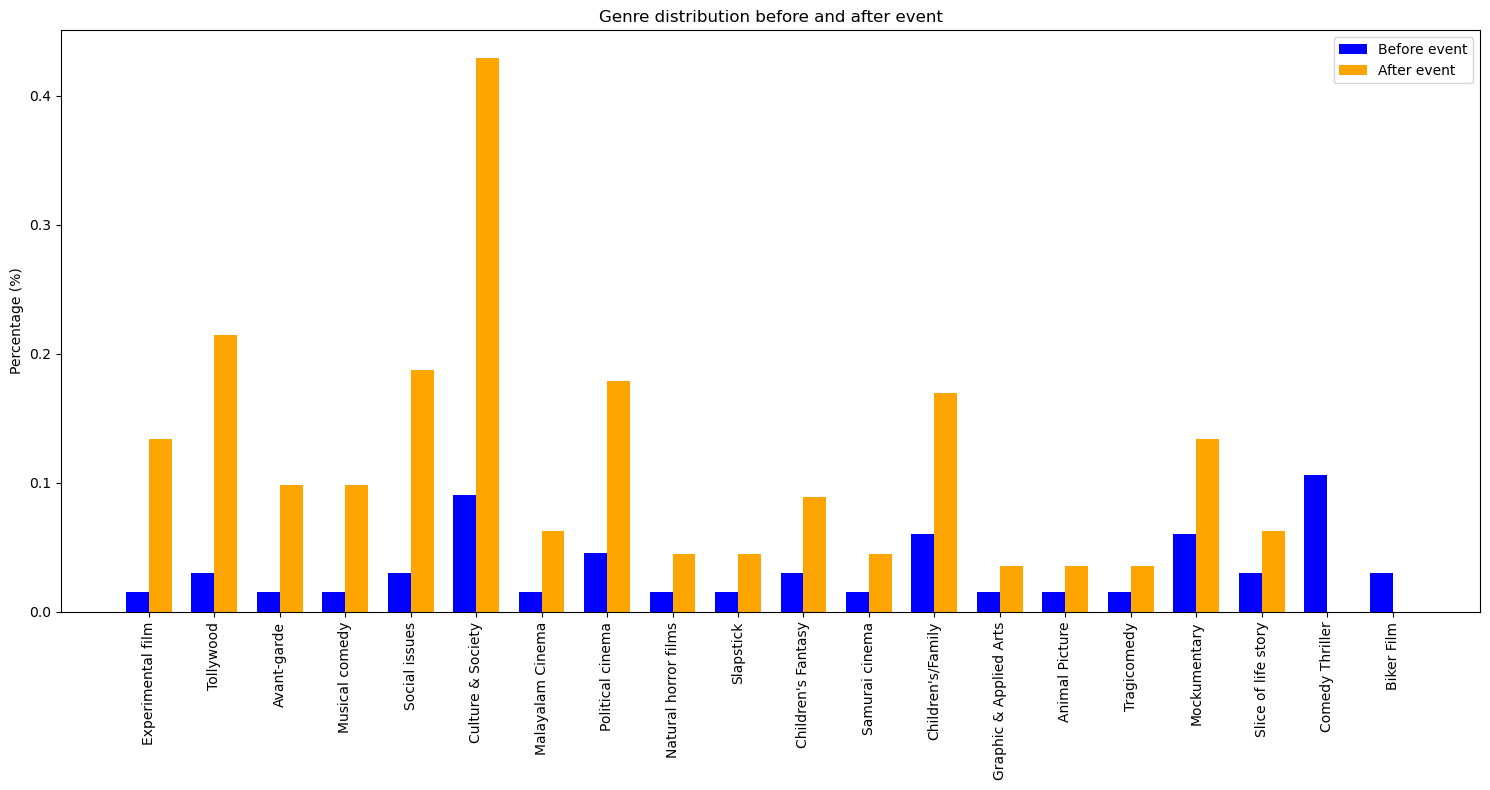

In [151]:
df = get_movies_genre_change(nonus_movies, genres_unique, 20, 1997,  2002,2006)
plot_movies_genre_change(df)

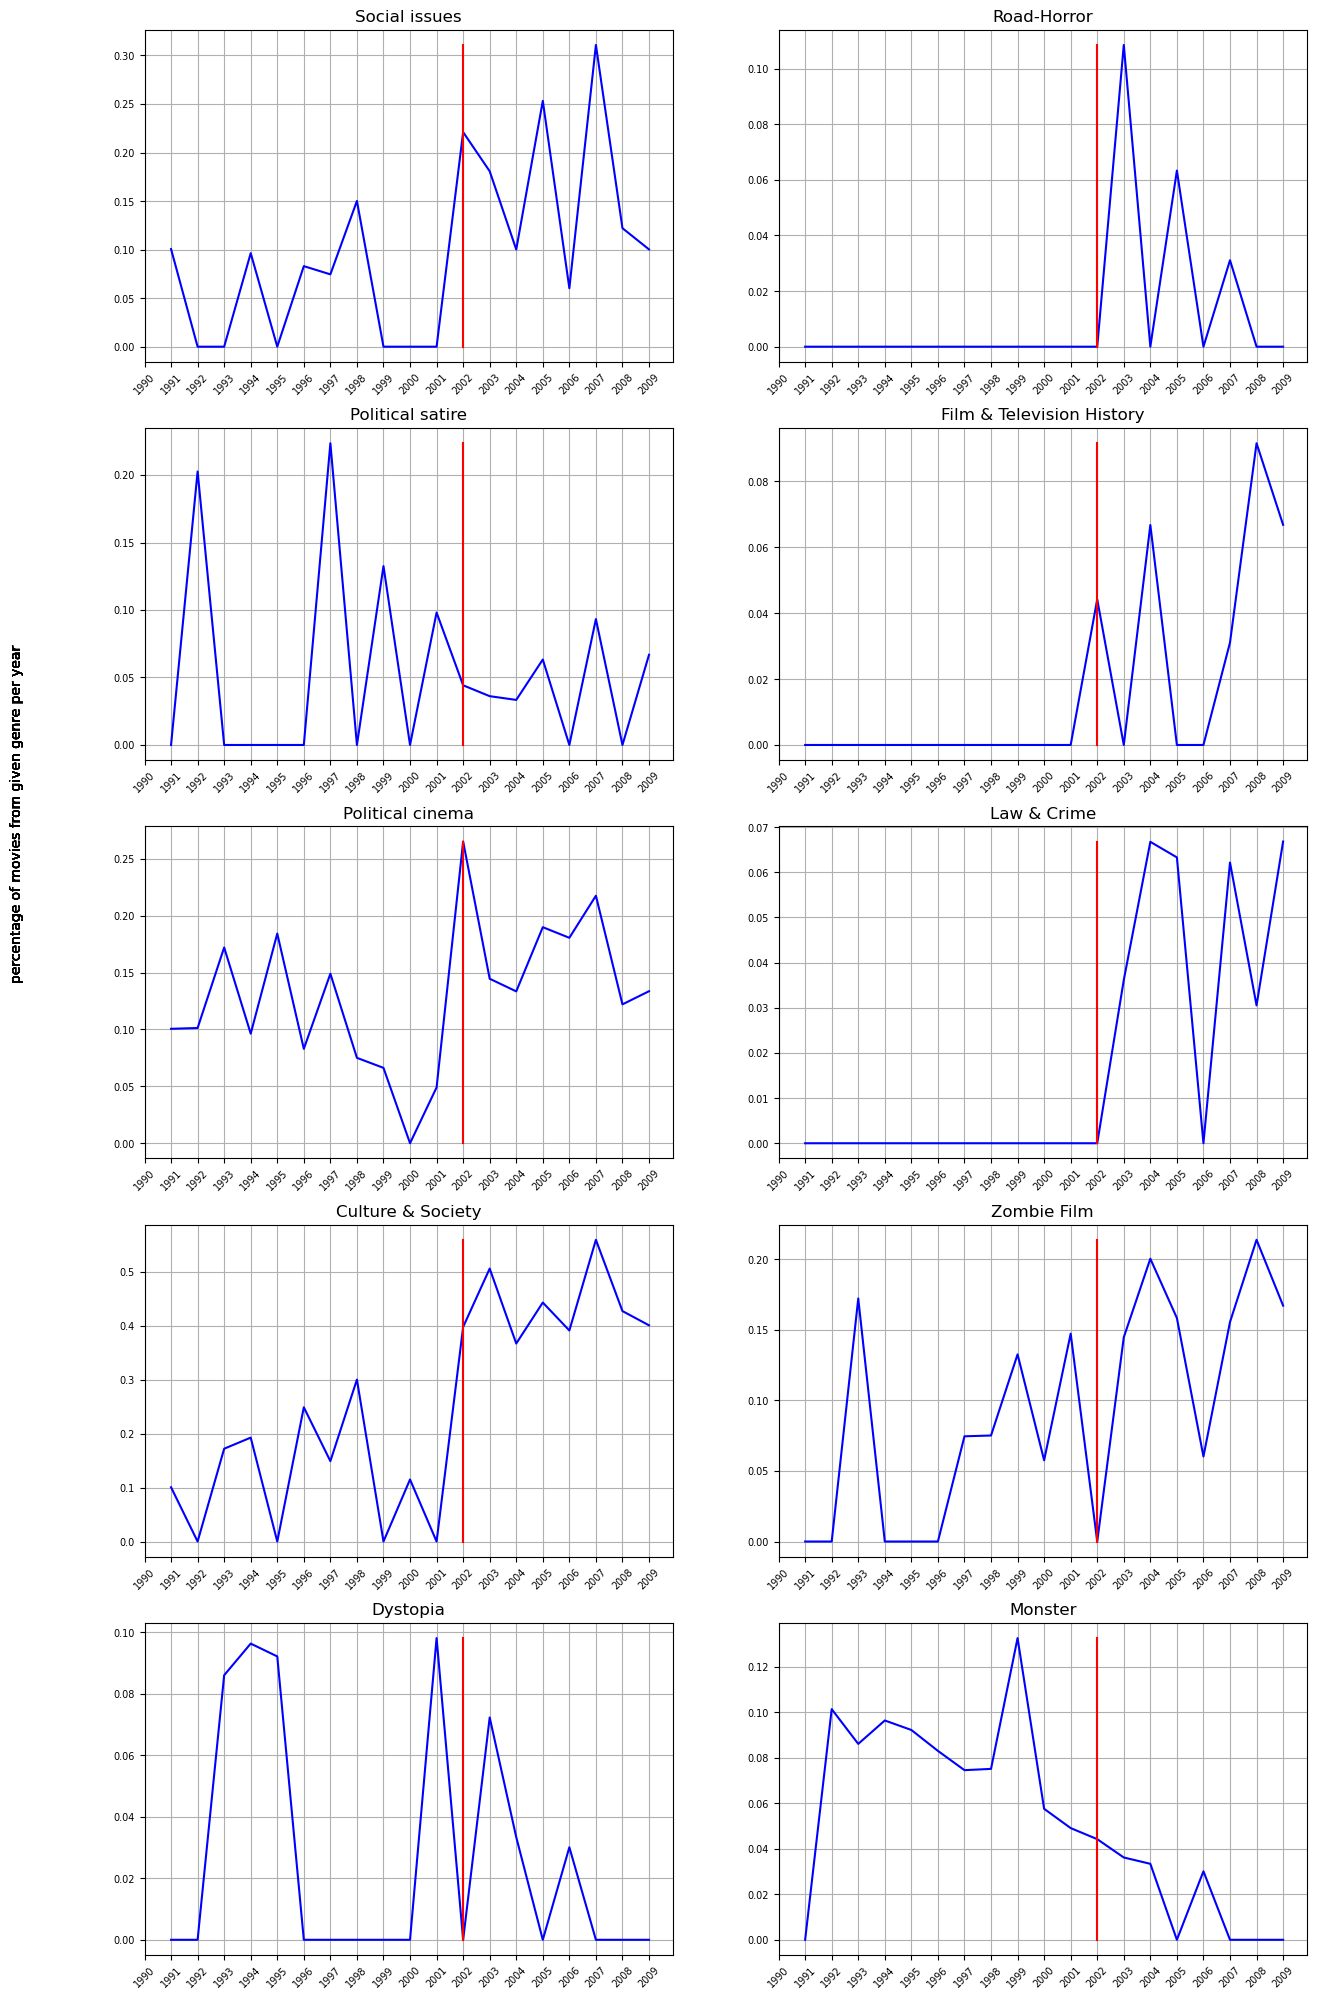

In [152]:
df = get_movies_genre_change(nonus_movies, genres_unique, 10, 1997,  2002,2006)
#genres =['Social issues','Road-Horror','Political cinema','Political satire', 'Law & Crime','Illnesses & Disabilities','Holiday Film','Social problem film','Glamorized Spy Film','Swashbuckler films','Dystopia', 'Documentary']
plot_percentage_movies_genre_all(nonus_movies,genres,1990, 2010, 2002,5,2)

We observe that the 20 genres with the highest changes are not completely identical between the U.S. and the rest of the world. Additionally, examining the time series for each genre studied in the U.S., we see that genres like political cinema, for example, show different trends in variation when compared to their counterparts outside the U.S.